In [20]:
import os
import numpy as np
from sklearn.decomposition import PCA
import torch

def read_amc_file(file_path):
    print('Reading file %s'%file_path)
    num_sensors = 29
    walk_timeseries_data = []
    with open(file_path, 'r') as file:
        lines = file.read().splitlines() # Each line is a list of elements
        lines = lines[3:]
        p = 0 # index in lines
        while True: # Each line in [lines] is 'sensor_name sensor_data
            timestamp = int(lines[p])
            timestamp_data = []

            for i in range(num_sensors):
                sensor_line = lines[p+i+1].split(' ') # Read from p + i + 1 line (measurement of first sensor of timestamp p)
                next = False
                sensor_data = []
                k = 1
                while next == False:  # Reading sensor data
                    try:
                        s = float(sensor_line[k])
                        sensor_data.append(s)
                        k += 1
                    except:
                        next = True
                timestamp_data.append(sensor_data) 
                
            walk_timeseries_data.append(timestamp_data)
            p += num_sensors + 1
            if p >= len(lines):
                break
        return walk_timeseries_data

def column_pca(walk_timeseries_data, rowshape=False):
    pca = PCA(1)
    num_sensors = 29 # D
    walk_timeseries_data_pca = np.empty((len(walk_timeseries_data), num_sensors)) # T x D
    j = 0
    for sensor in range(num_sensors):
        sensor_data_over_time = np.array([walk_timeseries_data[i][sensor] for i in range(len(walk_timeseries_data))]) # T x M, M:[1..6]
        if sensor_data_over_time.shape[1] > 1: # M > 1
            sensor_data_over_time_pca = pca.fit_transform(sensor_data_over_time) # T x 1
        else:
            sensor_data_over_time_pca = sensor_data_over_time # M == 1
        walk_timeseries_data_pca[:, j:j+1] = sensor_data_over_time_pca
        j += 1
    if rowshape:
        walk_timeseries_data_pca = walk_timeseries_data_pca.reshape(walk_timeseries_data_pca.shape[0]*walk_timeseries_data_pca.shape[1]) # (1, T*D) shape
    return walk_timeseries_data_pca

def build_dataset_long(X):
    limit_time = 100 # T
    num_sensors = 29 # D
    nrows = limit_time * len(X)
    X_pca = np.empty((nrows, num_sensors)) # NT x D
    i = 0
    for walk_timeseries_data in X:
        # apply column-PCA separately to each file/time-series
        walk_timeseries_data_pca = column_pca(walk_timeseries_data, rowshape=False)[:limit_time,:] # T x D
        X_pca[i:i+limit_time, :] = walk_timeseries_data_pca
        i += limit_time 
    return X_pca

def build_dataset_wide_full(X, T):
    limit_time = T # T
    nrows = len(X)
    num_sensors = 29
    D = 62
    X_full = np.empty((nrows, limit_time*D)) # N x TD
    j = 0
    for walk_timeseries_data in X: # for each file/time-series
        file_measures = []
        for t in range(limit_time):
            file_measures_time_t = []
            for i in range(num_sensors):
                file_measures_time_t.append(walk_timeseries_data[t][i])
            file_measures_time_t = np.array([m for sublist in file_measures_time_t for m in sublist]) # D,
            file_measures.append(file_measures_time_t)
        X_full[j:j+1,:] = np.concatenate(file_measures, axis=0).reshape(1,-1)
        j += 1
    return X_full

def build_dataset_wide(X):
    limit_time = 100
    num_sensors = 29
    ncols = num_sensors * limit_time
    X_pca = np.empty((len(X), num_sensors * limit_time)) # N x TD
    i = 0
    for walk_timeseries_data in X:
        walk_timeseries_data_pca = column_pca(walk_timeseries_data, rowshape=True)[:ncols] # 1 x TD
        X_pca[i:i+1, :] = walk_timeseries_data_pca.reshape(1,-1)
        i += 1
    return X_pca

def build_dataset_tensor(X):
    limit_time = 100
    num_sensors = 29
    N = len(X)
    X_pca = np.empty((N, limit_time, num_sensors))  # N x T x D
    i = 0
    for walk_timeseries_data in X:
        walk_timeseries_data_pca = column_pca(walk_timeseries_data, rowshape=False)[:limit_time,:] # T x D
        X_pca[i:i+1, :, :] = walk_timeseries_data_pca
        i += 1
    return X_pca

In [6]:
# Read walk files
X = []
for filename in os.listdir('walk/'):
    if filename.endswith(".amc") and filename.startswith("07"):
        file_path = os.path.join('walk/', filename)
        walk_timeseries_data = read_amc_file(file_path)
        X.append(walk_timeseries_data)
        #walk_timeseries_data_pca = column_pca(walk_timeseries_data)
# NOTE: SUBJECT 07_12 THERE WAS NOT ltoes MEASUREMENT FOR THE LAST TIMESTAMP, I PUT IT EQUAL TO THE PREVIOUS TIMESTAMP


T = 100 # -> I fixed a limit on the number of timestaps i consider for each file 
N = len(X) # of files (samples)
D = 62
X_NxTD_walk = build_dataset_wide_full(X, T) # N x TD [D=62]
X_NTxD_walk = X_NxTD_walk.reshape(N*T,D) # TD x N [D=62]
#X_long_walk = build_dataset_long(X) # NT x D [D=29]
#X_wide_walk = build_dataset_wide(X) # N x TD [D=29]
#X_tensor_walk = build_dataset_tensor(X) # N x T x D [D=29]

Reading file walk/07_03.amc
Reading file walk/07_02.amc
Reading file walk/07_01.amc
Reading file walk/07_05.amc
Reading file walk/07_11.amc
Reading file walk/07_10.amc
Reading file walk/07_04.amc
Reading file walk/07_12.amc
Reading file walk/07_06.amc
Reading file walk/07_07.amc
Reading file walk/07_09.amc
Reading file walk/07_08.amc


## Create regression data

In [10]:
onewalk_data = read_amc_file('walk/07_01.amc')
X_TxD = build_dataset_wide_full([onewalk_data], len(onewalk_data)).reshape(len(onewalk_data), D)
X, Y = X_TxD[:,:-1], X_TxD[:,-1].reshape(-1,1)
np.savez('mocap_data_regression.npz', X=X, Y=Y)

Reading file walk/07_01.amc


In [11]:
X_TxD[:,-1].reshape(-1,1).shape

(316, 1)

In [12]:
# Read run files
X = []
for filename in os.listdir('run/'):
    if filename.endswith(".amc"):
        file_path = os.path.join('run/', filename)
        walk_timeseries_data = read_amc_file(file_path)
        X.append(walk_timeseries_data)
N = len(X)
T = 100
D = 62
X_NxTD_run = build_dataset_wide_full(X, T) # N x TD [D=62]
X_NTxD_run = X_NxTD_run.reshape(N*T,D) # TD x N [D=62]
#X_long_run = build_dataset_long(X) # NT x D
#X_wide_run = build_dataset_wide(X) # N x TD
#X_wide_run_full = build_dataset_wide_full(X) # N x TD [D=62]
#X_tensor_run = build_dataset_tensor(X) # N x T x D

Reading file run/16_52.amc
Reading file run/16_46.amc
Reading file run/16_53.amc
Reading file run/16_45.amc
Reading file run/16_51.amc
Reading file run/16_50.amc
Reading file run/16_44.amc
Reading file run/16_40.amc
Reading file run/16_54.amc
Reading file run/16_55.amc
Reading file run/16_41.amc
Reading file run/16_57.amc
Reading file run/16_43.amc
Reading file run/16_42.amc
Reading file run/16_56.amc
Reading file run/16_37.amc
Reading file run/35_17.amc
Reading file run/16_36.amc
Reading file run/16_08.amc
Reading file run/16_35.amc
Reading file run/16_38.amc
Reading file run/35_18.amc
Reading file run/35_24.amc
Reading file run/35_25.amc
Reading file run/35_19.amc
Reading file run/16_39.amc
Reading file run/35_26.amc
Reading file run/35_22.amc
Reading file run/35_23.amc
Reading file run/35_21.amc
Reading file run/35_20.amc
Reading file run/16_49.amc
Reading file run/16_48.amc
Reading file run/02_03.amc
Reading file run/38_03.amc


In [13]:
# Merge data
Y_walk = np.zeros(X_NxTD_walk.shape[0])
Y_run = np.ones(X_NxTD_run.shape[0])
Y = np.concatenate((Y_walk, Y_run)).reshape(-1,1)
X_NxTD = np.vstack((X_NxTD_walk, X_NxTD_run))
X_NTxD = np.vstack((X_NTxD_walk, X_NTxD_run))
print('N.walk = ', X_NxTD_walk.shape[0])
print('N.run = ', X_NxTD_run.shape[0])

N.walk =  12
N.run =  35


In [8]:
# 62 features version
sensors_names = ['root','lowerback','upperback','thorax','lowerneck','upperneck','head','rclavicle','rhumerus','rradius','rwrist','rhand','rfingers','rthumb','lclavicle','lhumerus','lradius','lwrist','lhand','lfingers','lthumb','rfemur','rtibia','rfoot','rtoes','lfemur','ltibia','lfoot','ltoes']
s_mask = []
for sensor_j_measure in X[0][0]:
    s_mask.append(len(sensor_j_measure))
s_names_mask = []
for i, sensor_name in enumerate(sensors_names):
    s_names_mask.append([sensor_name] * s_mask[i])
s_names_mask_flat = []
for row in s_names_mask:
    s_names_mask_flat.extend(row)
sensors_names = np.array(s_names_mask_flat) 
sensors_mask = np.cumsum(np.array(s_mask))

In [7]:
# remove: rhand, rfingers, rthumb, lhand, lfingers, lthumb, rtoes, ltoes
s_names_mask_flat.remove('rhand')
s_names_mask_flat.remove('lhand')
s_names_mask_flat.remove('rfingers')
s_names_mask_flat.remove('lfingers')
s_names_mask_flat.remove('rthumb')
s_names_mask_flat.remove('lthumb')
s_names_mask_flat.remove('rtoes')
s_names_mask_flat.remove('ltoes')
sensors_names_50 = np.array(s_names_mask_flat) 


NameError: name 's_names_mask_flat' is not defined

In [175]:
np.savez('mocap_data.npz', X_NxTD=X_NxTD, X_NTxD=X_NTxD, Y=Y, sensors_names=sensors_names, sensors_mask=sensors_mask)

In [55]:
#generate_mocap_raw
from generate_mocap_raw import create_mocap09
import numpy as np

create_mocap09(small_skeleton=True)
mocap9_smallsk = np.load('./mocap09_smallsk.npz')

In [64]:
mocap9 = np.load('./mocap09.npz')

In [40]:
sensors_names = ['root','lowerback','upperback','thorax','lowerneck','upperneck','head','rclavicle','rhumerus','rradius','rwrist','rhand','rfingers','rthumb','lclavicle','lhumerus','lradius','lwrist','lhand','lfingers','lthumb','rfemur','rtibia','rfoot','rtoes','lfemur','ltibia','lfoot','ltoes']
sensors_measures = [6,3,3,3,3,3,3,2,3,1,1,2,1,2,2,3,1,1,2,1,2,3,1,2,1,3,1,2,1]
s_names_measures = []
for i, sensor_name in enumerate(sensors_names):
  s_names_measures.append([sensor_name] * sensors_measures[i])
mask = [31, 32, 33, 34, 35, 43, 44, 45, 46, 47, 54, 61]
mask_sensors_names = [11,12,13,18,19,20,24,28]
s_names_measures = np.array([item for s_names_measures in s_names_measures for item in s_names_measures])
s_names_measures_50 = np.delete(s_names_measures, mask, 0).tolist()
s_sep_50 = np.cumsum(np.delete(np.array(sensors_measures), mask_sensors_names, 0))
sensors_measures_21 = np.insert(s_sep_50, 0, 0)
sensors_names_21 = list(dict.fromkeys(s_names_measures_50))

In [18]:
measures_per_sensor_50 = np.delete(np.array(sensors_measures), mask_sensors_names, 0)
measures_per_sensor_50

array([6, 3, 3, 3, 3, 3, 3, 2, 3, 1, 1, 2, 3, 1, 1, 3, 1, 2, 3, 1, 2])

In [65]:
# Select only first measurement of each sensor
def select_first_measure(x):
    N, T, D = x.shape
    d = 21
    x_stacked = np.vstack([x[i] for i in range(x.shape[0])])
    x_stacked_first_measure = np.empty((N*T, d))
    i = 0
    j = 0
    for sensor_n_measures in measures_per_sensor_50:
        x_stacked_sensor = x_stacked[:,i:i+sensor_n_measures] # NT x S
        x_ = x_stacked_sensor[:,0:1]
        x_stacked_first_measure[:,j:j+1] = x_
        j += 1
        i += sensor_n_measures
    x_ = np.concatenate([np.expand_dims(x_stacked_first_measure[i * T:(i + 1) * T], 0) for i in range(N)], 0)
    return x_
x_first_measure = [select_first_measure(x) for x in [mocap9['train'], mocap9['test'], mocap9['validation']]]
np.savez('mocap09_m1.npz', test=x_first_measure[1], validation=x_first_measure[2], train=x_first_measure[0])

In [67]:
mocap9['train']

array([[[-2.15476084e-02, -4.99820000e-02, -7.69063333e-02, ...,
         -6.13890306e+00, -2.22274282e+01, -1.43825994e+00],
        [-4.36460842e-03, -7.49820000e-02, -4.43063333e-02, ...,
         -6.14860306e+00, -2.32538282e+01, -1.31477994e+00],
        [-1.29996084e-02, -3.37820000e-02, -6.67063333e-02, ...,
         -5.89970306e+00, -2.48859282e+01, -6.16839943e-01],
        ...,
        [ 1.88033916e-02, -7.88200000e-03,  1.28936667e-02, ...,
         -4.94249031e+01,  2.96634718e+01,  8.00781006e+00],
        [ 3.43163916e-02, -2.78200000e-03,  1.78936667e-02, ...,
         -4.41547631e+01,  2.72059718e+01,  6.43802006e+00],
        [ 3.43163916e-02, -2.78200000e-03,  1.78936667e-02, ...,
         -3.75802031e+01,  2.47300718e+01,  5.34743006e+00]],

       [[ 3.74049158e-03,  7.53180000e-02,  1.94936667e-02, ...,
         -8.23530306e+00, -2.77023282e+01,  2.87628406e+00],
        [ 2.40291583e-04,  8.25180000e-02,  2.05936667e-02, ...,
         -1.02217031e+01, -2.58355282e

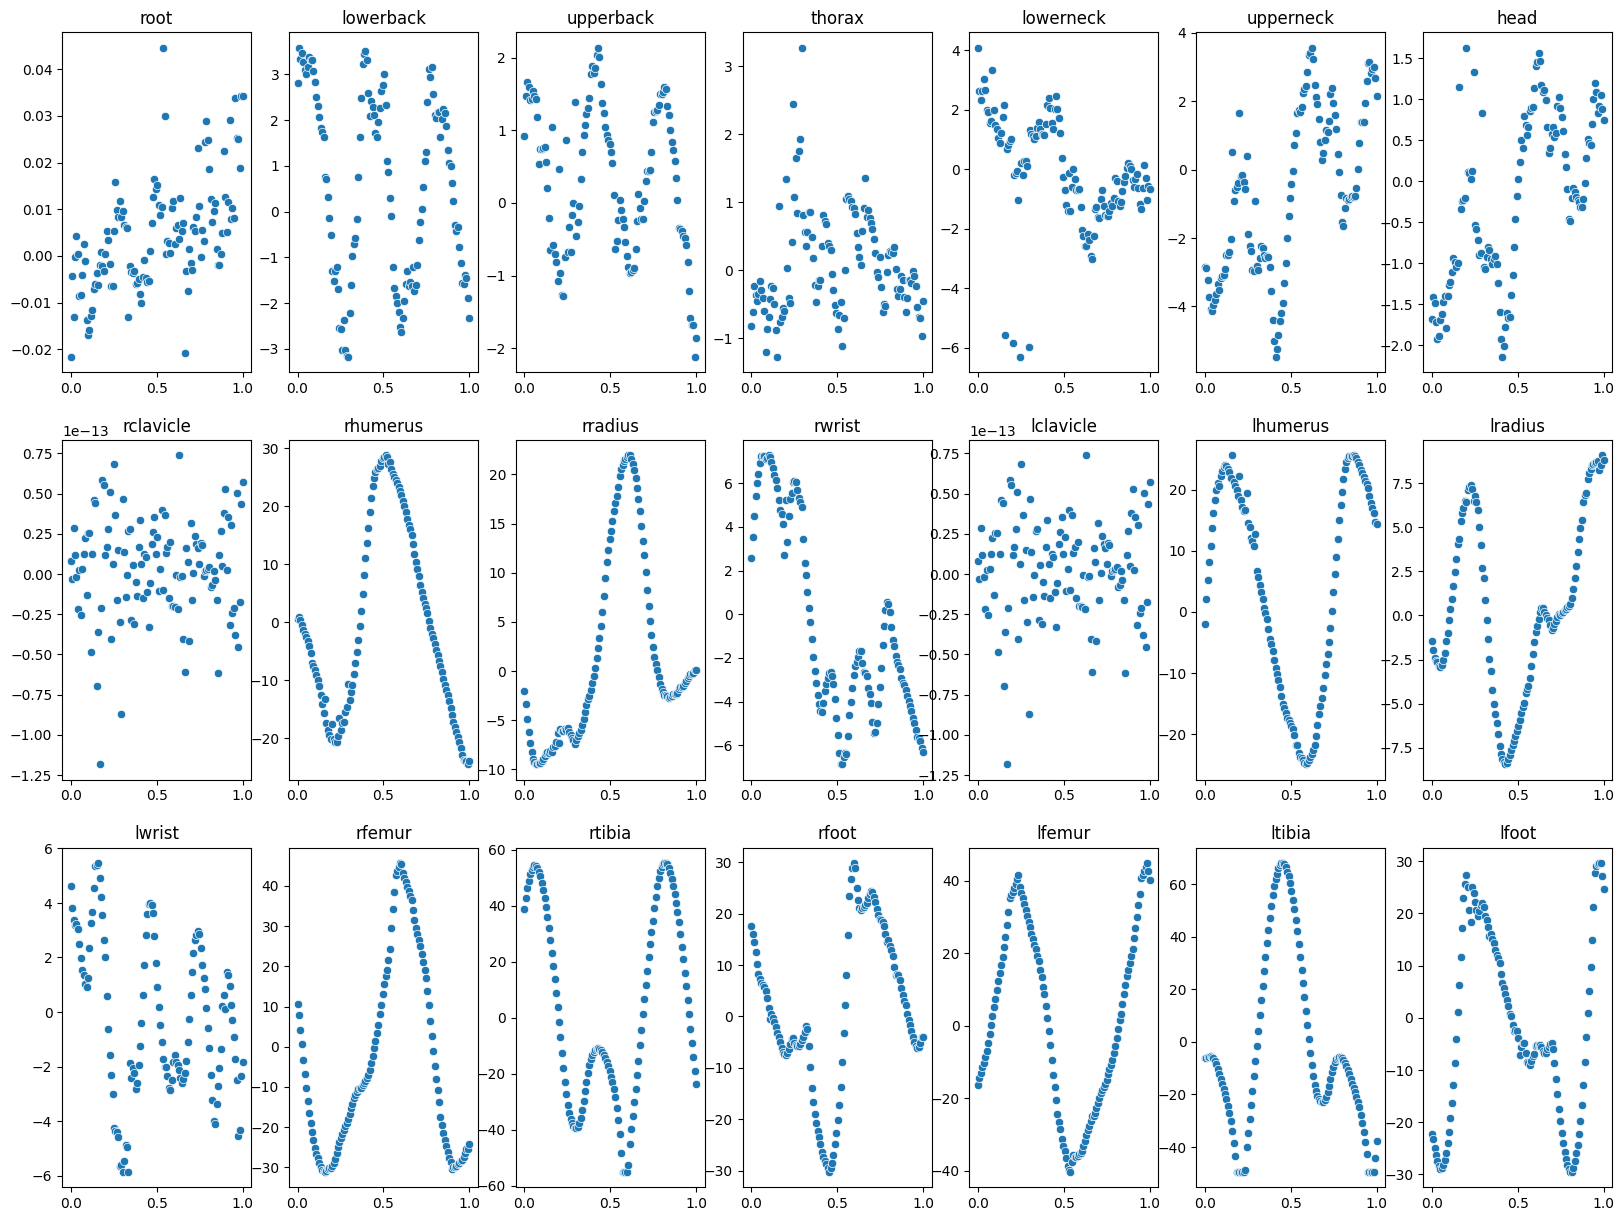

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 7, figsize=(20, 15))
k = 0
xs_train = x_first_measure[0]
for i in range(3):
    for j in range(7):
        sns.scatterplot(x=np.linspace(0,1,xs_train.shape[1]), y=xs_train[0,:,k], ax=axs[i,j])
        axs[i,j].set_title(sensors_names_21[k])
        k += 1

In [57]:
# Apply Sensor-wise PCA
def sensor_wise_pca(x):
    N, T, D = x.shape
    d = 21
    x_stacked = np.vstack([x[i] for i in range(x.shape[0])])
    x_stacked_pca = np.empty((N*T, d))
    i = 0
    j = 0
    for sensor_n_measures in measures_per_sensor_50:
        x_stacked_sensor = x_stacked[:,i:i+sensor_n_measures] # NT x S
        pca = PCA(n_components=1)
        x_ = pca.fit_transform(x_stacked_sensor) # NT x d
        x_stacked_pca[:,j:j+1] = x_
        j += 1
        i += sensor_n_measures
    x_ = np.concatenate([np.expand_dims(x_stacked_pca[i * T:(i + 1) * T], 0) for i in range(N)], 0)
    return x_
x_pca = [sensor_wise_pca(x) for x in [mocap9['train'], mocap9['test'], mocap9['validation']]]
np.savez('mocap09_pca.npz', test=x_pca[1], validation=x_pca[2], train=x_pca[0])

In [54]:
# Normalize data
class Normalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, x):
        return (x - self.mean) / self.std

    def inverse(self, x):
        return (x * self.std) + self.mean
data_std = x_pca[0][:, :].std((0, 1), keepdims=True) + 1e-5
data_mean = x_pca[0][:, :].mean((0, 1), keepdims=True)
data_normalize = Normalize(data_mean,data_std)
xs_train, xs_valid, xs_test = data_normalize(x_pca[0]), data_normalize(x_pca[2]), data_normalize(x_pca[1])
np.savez('mocap09_pca.npz', test=xs_test, validation=xs_valid, train=xs_train)

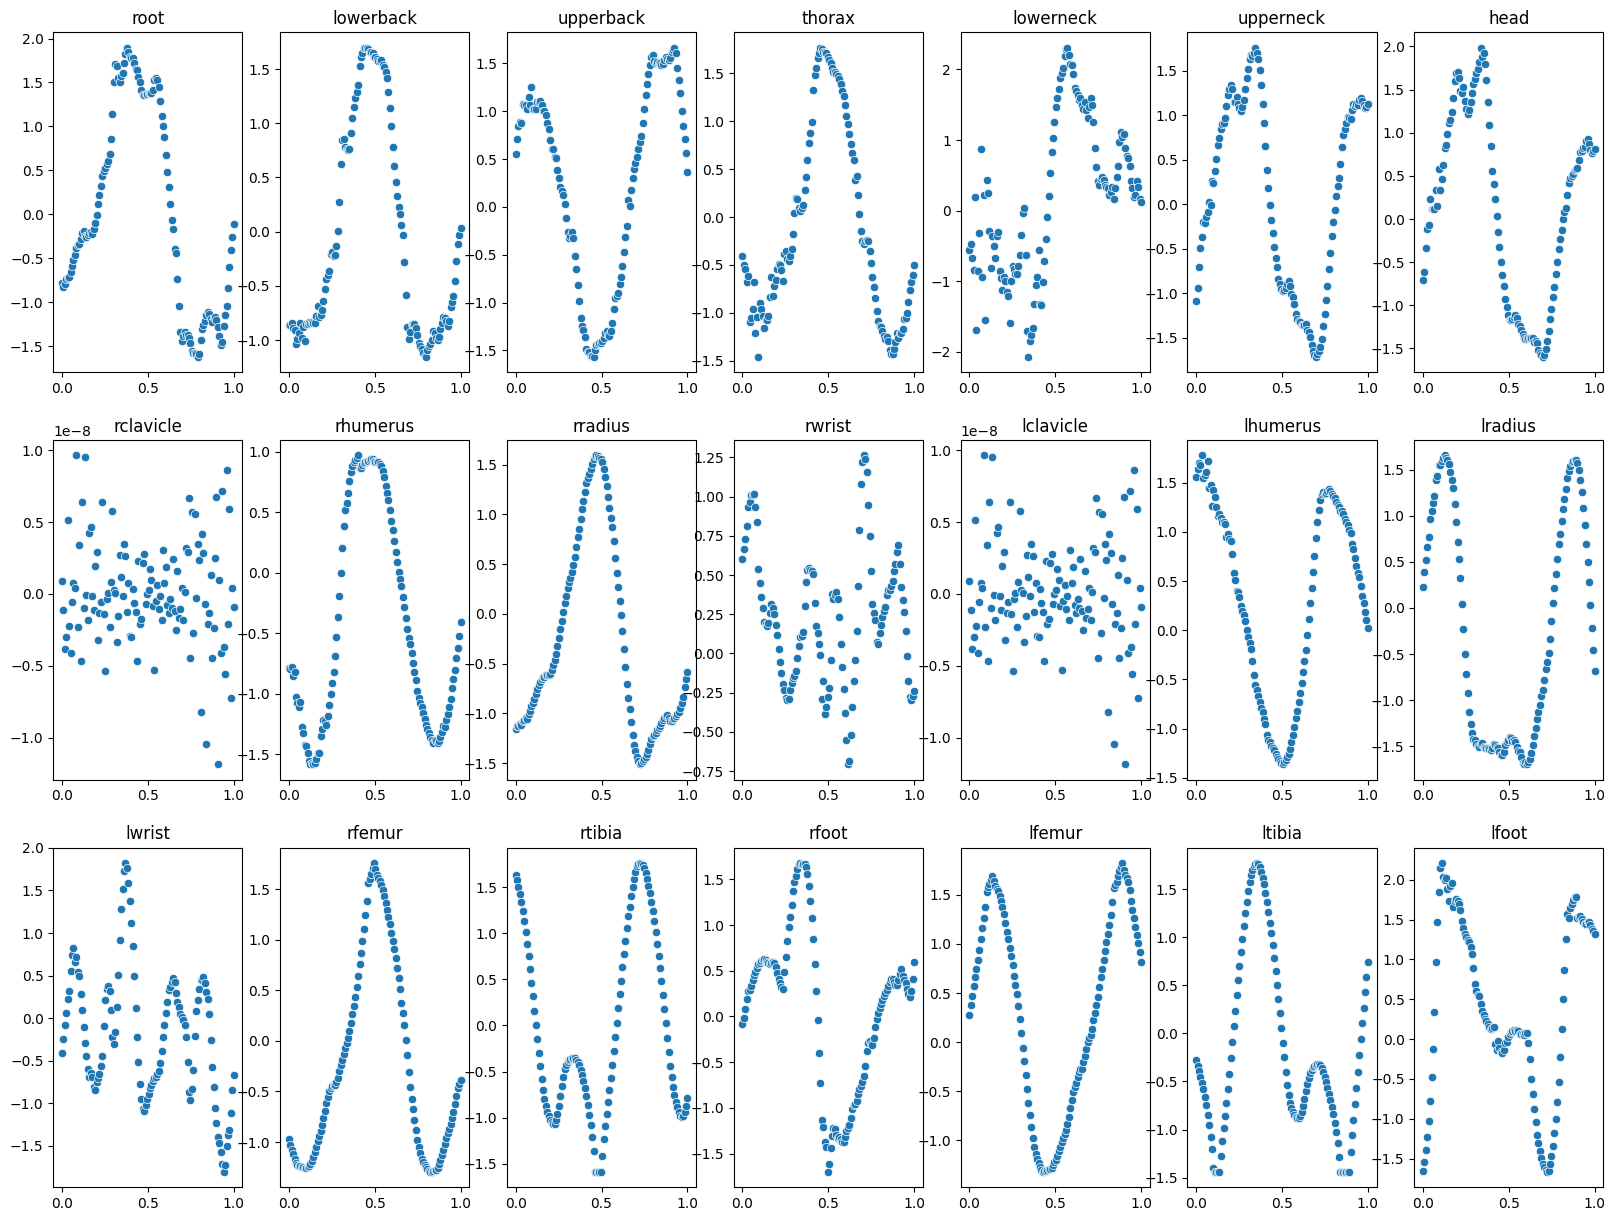

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 7, figsize=(20, 15))
k = 0
for i in range(3):
    for j in range(7):
        sns.scatterplot(x=np.linspace(0,1,xs_train.shape[1]), y=xs_train[0,:,k], ax=axs[i,j])
        axs[i,j].set_title(sensors_names_21[k])
        k += 1

In [39]:
np.savez('mocap09_pca.npz', test=x_pca[1], validation=x_pca[2], train=x_pca[0])

In [46]:
for i,name in enumerate(sensors_names_21):
    print(name,i)

root 0
lowerback 1
upperback 2
thorax 3
lowerneck 4
upperneck 5
head 6
rclavicle 7
rhumerus 8
rradius 9
rwrist 10
lclavicle 11
lhumerus 12
lradius 13
lwrist 14
rfemur 15
rtibia 16
rfoot 17
lfemur 18
ltibia 19
lfoot 20
